# Algoritmo de Simon (Simon's algorithm)

## Descripción general

El **Algoritmo de Simon** es un protocolo cuántico diseñado para resolver un problema de "período oculto".

Se nos da una función "oráculo" $f(x)$ que toma $n$ bits de entrada y devuelve $n$ bits de salida ($f: \{0,1\}^n \to \{0,1\}^n$). Se nos **promete** que esta función es 2-a-1 y que existe un "string secreto" (o máscara) $s \in \{0,1\}^n$ tal que:

$f(x) = f(y)$ si y solo si $y = x \oplus s$

(Donde $\oplus$ es el XOR bit a bit). Si $s = 00...0$, la función es 1-a-1 (una permutación). Si $s \neq 00...0$, la función es 2-a-1.

**El objetivo del algoritmo es encontrar el string secreto $s$.**

### Recursos utilizados
- $2n$ qubits (Usaremos $n=3$, por lo tanto, 6 qubits).
- $n$ bits clásicos (Usaremos 3 bits).
- 1 consulta al oráculo cuántico (`U_f`) por ejecución.

### Idea principal
Clásicamente, encontrar $s$ requiere un número exponencial de consultas. El algoritmo de Simon, mediante superposición e interferencia, nos da una pista sobre $s$ con **cada consulta**.

Cada ejecución nos da un string $z$ tal que la paridad (producto punto módulo 2) de $z$ y $s$ es 0:
$z \cdot s = 0 \pmod 2$

Repitiendo el algoritmo $\sim n$ veces, obtenemos un sistema de ecuaciones lineales que nos permite despejar $s$ eficientemente.



In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import Aer
from qiskit_ibm_runtime import Sampler

# Cargar credenciales (este paso es opcional, se puede simular)
try:
    service = QiskitRuntimeService()  # usa cuenta previamente guardada
    backend = service.backend("ibm_brisbane") #Utilizamos Brisbane, pero se puede utilizar ibm_torino
    print("Conexión con IBM Quantum Platform exitoso")
except Exception:
    backend = Aer.get_backend("aer_simulator")
    print("Utilizando el simulador de AER")

Conexión con IBM Quantum Platform exitoso


## Procedimiento

El protocolo consta de **cinco etapas** principales (para $n$ bits de entrada):

1.  **Preparación de Registros:**
    * Se inicializan $n$ qubits del "registro de entrada" (ej. `q0, q1, q2`) en el estado $|0\rangle$.
    * Se inicializan $n$ qubits del "registro de salida" (ej. `q3, q4, q5`) en el estado $|0\rangle$.

2.  **Superposición:**
    * Se aplica una compuerta Hadamard (`H`) a **todos** los $n$ qubits del **registro de entrada** (no al de salida).

3.  **Oráculo:**
    * Se aplica el oráculo cuántico `U_f`, que entrelaza el registro de entrada con el de salida, calculando $f(x)$.

4.  **Interferencia:**
    * Se aplica una compuerta Hadamard (`H`) de nuevo, *solo* a los $n$ qubits del **registro de entrada**.

5.  **Medición:**
    * Se miden *solo* los $n$ qubits del **registro de entrada**.

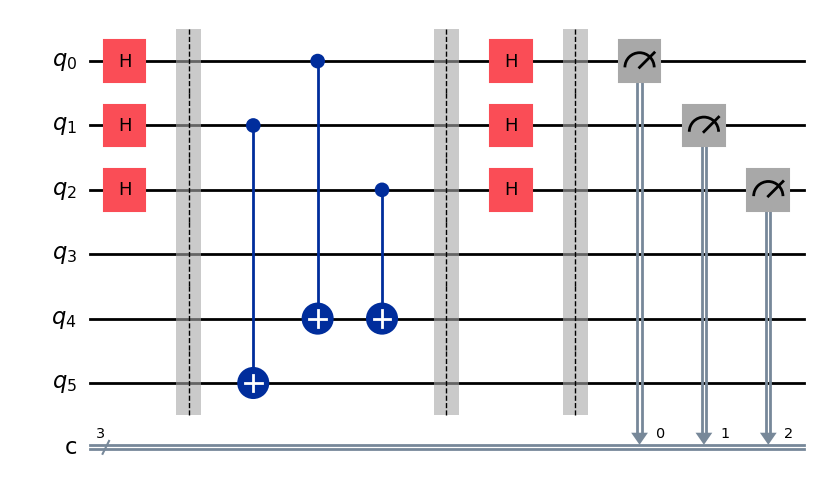

In [6]:
# Definir los registros (n=3) 
qc = QuantumCircuit(6, 3)

# Superposición 
qc.h([0, 1, 2]) # Aplicamos H solo al registro de entrada
qc.barrier()

# Oráculo (para s = 101) 
# Implementamos un oráculo 2-a-1: f(x) = (x1, x0 XOR x2, 0)
# (El output irá a q5, q4, q3)

# f2 = x1
qc.cx(1, 5)

# f1 = x0 XOR x2
qc.cx(0, 4)
qc.cx(2, 4)

# f0 = 0 (no hacemos nada en q3)

qc.barrier()

#  Interferencia 
qc.h([0, 1, 2]) # Aplicamos H solo al registro de entrada
qc.barrier()

# Medición 
qc.measure([0, 1, 2], [0, 1, 2]) # Medimos solo el registro de entrada

# Dibujar el circuito 
qc.draw("mpl")

### Explicación del circuito
- **Registros:** `q0, q1, q2` (entrada $x$) y `q3, q4, q5` (salida $f(x)$).
- **Superposición:** Las primeras `H` ponen el registro de entrada en una superposición de todos los 8 estados posibles.
- **Oráculo:** La sección central implementa la función 2-a-1 con $s=101$. Es nuestra "caja negra".
- **Interferencia:** Las segundas `H` hacen que los estados interfieran. La teoría de Simon predice que el estado final del registro de entrada será una superposición de todos los strings $z$ que son "ortogonales" al string secreto $s$ (es decir, $z \cdot s = 0 \pmod 2$).
- **Medición:** Medimos el registro de entrada para obtener uno de esos strings $z$.

Transpilando el circuito para el backend...
Transpilación completada.
Enviando trabajo al Sampler...
Trabajo completado.
Resultados de la medición de los qubits de entrada:


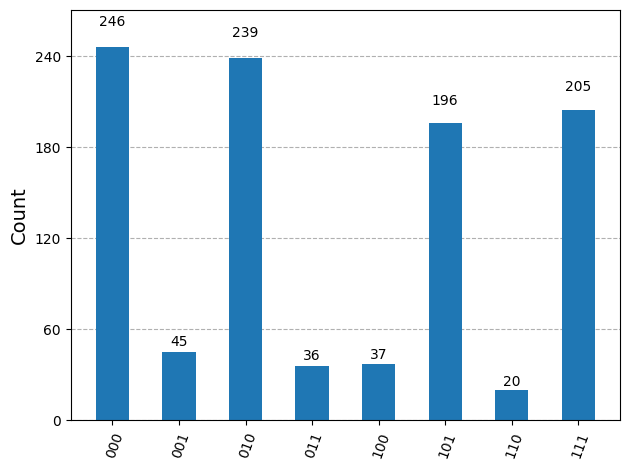

In [7]:
# Ejecución del circuito 

# Transpila tu circuito lógico 'qc' para el 'backend'
print("Transpilando el circuito para el backend...")
tqc = transpile(qc, backend=backend)
print("Transpilación completada.")

# Instancia el Sampler (Primitivo V2) pasando el backend
sampler = Sampler(mode=backend)
print("Enviando trabajo al Sampler...")

# Ejecuta el .run() con el circuito yatranspilado (tqc) y los shots
job = sampler.run([tqc], shots=1024) 
result = job.result()
print("Trabajo completado.")

# Obtén los resultados del formato V2
pub_result = result[0]
counts = pub_result.data.c.get_counts()

# Visualización
print("Resultados de la medición de los qubits de entrada:")
plot_histogram(counts)

### Interpretación de resultados
- El histograma muestra los strings $z$ medidos en el registro de entrada.
- **La teoría predice:**
    - Todos los strings $z$ que midamos deben cumplir $z \cdot s = 0 \pmod 2$.
    - Para nuestro secreto $s = 101$:
        - $z \cdot (101) = z_0 \cdot 1 \oplus z_1 \cdot 0 \oplus z_2 \cdot 1 = z_0 \oplus z_2 = 0$.
    - Esto significa que $z_0$ debe ser igual a $z_2$ ($z_0 = z_2$).
- **Resultados esperados (para $s=101$):**
    - `000` (ya que 0 = 0)
    - `010` (ya que 0 = 0)
    - `101` (ya que 1 = 1)
    - `111` (ya que 1 = 1)
- En un simulador ideal, las cuentas para `001`, `011`, `100` y `110` deberían ser **cero**.
- El histograma debería mostrar cuentas solo para `000`, `010`, `101` y `111`.
- **Encontrando $s$:** Si obtenemos las mediciones $z_1 = 101$ y $z_2 = 010$ (necesitamos $n-1=2$ resultados linealmente independientes), podemos armar un sistema de ecuaciones para encontrar $s = (s_0, s_1, s_2)$:
    1. $z_1 \cdot s = 1 \cdot s_0 \oplus 0 \cdot s_1 \oplus 1 \cdot s_2 = 0 \implies s_0 = s_2$
    2. $z_2 \cdot s = 0 \cdot s_0 \oplus 1 \cdot s_1 \oplus 0 \cdot s_2 = 0 \implies s_1 = 0$
    - El único string (además de `000`) que satisface $s_1=0$ y $s_0=s_2$ es $s = 101$.

## Conclusión

El algoritmo de Simon es un claro ejemplo de una **ventaja cuántica exponencial** para un problema específico (en términos de consultas).

- A diferencia de Deutsch-Jozsa, la respuesta no es un "Sí" o "No", sino un string $z$ que nos da una pista sobre $s$.
- El algoritmo debe **ejecutarse múltiples veces** (un número lineal de veces, $n$) para recolectar suficientes pistas ($z_1, z_2, ...$) y resolver el sistema de ecuaciones para $s$.
- Clásicamente, este problema requiere un número exponencial de consultas.
- Simon fue la inspiración directa para el **Algoritmo de Shor** (para factorizar números), que también se basa en encontrar el período oculto de una función.